<p><img alt="logo" width="200" src="https://dl.dropboxusercontent.com/s/nm3k2p6i3k6d6gl/sctensor.png" align="left" /></p>

<h1>Exercise2: scTensorのデモ</h1>


このノートブックでは、1細胞RNA-Seqデータ内に含まれる細胞間相互作用（CCI）を検出するためのR/Bioconductorパッケージ、scTensorの使い方について説明します

まずは、このノートブックの実行に必要なパッケージのインストールとロードを行います

In [1]:
# パッケージインストール
install.packages(c("BiocManager", "IRdisplay"), repos="http://cran.r-project.org")
BiocManager::install(c("SingleCellExperiment", "LRBase.Hsa.eg.db", "MeSH.Hsa.eg.db"), suppressUpdates=TRUE)
remotes::install_github("rikenbit/scTensor")

# パッケージロード
library("scTensor")
library("SingleCellExperiment")
library("LRBase.Hsa.eg.db")
library("MeSH.Hsa.eg.db")
library("IRdisplay")


The downloaded binary packages are in
	/var/folders/k0/tk8gl4bj2_v2mbjx80ydsznw0000gn/T//RtmplBZnv3/downloaded_packages


Bioconductor version 3.9 (BiocManager 1.30.10), R 3.6.1 (2019-07-05)
Installing package(s) 'SingleCellExperiment', 'LRBase.Hsa.eg.db',
  'MeSH.Hsa.eg.db'



The downloaded binary packages are in
	/var/folders/k0/tk8gl4bj2_v2mbjx80ydsznw0000gn/T//RtmplBZnv3/downloaded_packages


installing the source packages ‘LRBase.Hsa.eg.db’, ‘MeSH.Hsa.eg.db’

Old packages: 'covr', 'e1071', 'future', 'roxygen2'
Skipping install of 'scTensor' from a github remote, the SHA1 (be3bf197) has not changed since last install.
  Use `force = TRUE` to force installation
Registered S3 method overwritten by 'seriation':
  method         from 
  reorder.hclust gclus


Registered S3 method overwritten by 'enrichplot':
  method               from
  fortify.enrichResult DOSE
Loading required package: SummarizedExperiment
Loading required package: GenomicRanges
Loading required package: stats4
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: 'BiocGenerics'

The following objects are masked from 'package:parallel':

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from 'package:stats':

   

今回は、[Li, Li et al., 2017, Cell](https://www.sciencedirect.com/science/article/pii/S1934590917300784?via%3Dihub)で報告された、ヒトの性腺内部に含まれる生殖系細胞（Germline Cells）と、ニッチ環境を形成する体細胞（Somatic Cells）間のCCIについて調べます


<p><img alt="logo2" width="1000" src="https://dl.dropboxusercontent.com/s/bax9wbdsulr15tj/germline.jpg" /></p>

[RNA-Seq Blog](https://www.rna-seqblog.com/single-cell-rna-seq-analysis-maps-development-of-human-germline-cells/)


この論文に関係したデータは、以下の3つのRオブジェクトとして、scTensorパッケージ内に保存されているため、data関数で以下のように呼び出すことができます

なお、__発現量行列の遺伝子は、テストデータとして公開する際、データサイズの制限で、[Highly Variable Genes](http://pklab.med.harvard.edu/scw2014/subpop_tutorial.html)という基準のもと、かなり数を減らしているので、ここでは、あくまでツールの操作感を知るためにこのデータを用います__（生物学的考察までは保証しません、例えば、この論文で注目している、BMPシグナル系のリガンド・受容体ペアの発現は、数を減らした関係で再現できていません）

In [2]:
data(GermMale) # 発現量行列
data(labelGermMale) # 細胞型ラベル
data(tsneGermMale) # t-SNEの二次元座標

以下のように、GermMaleは行列、labelGermMaleはベクトルです

tsneGermMaleはRtsneという別のRパッケージの出力オブジェクトであり、tsneGermMale$Yの部分に、t-SNEの二次元座標が保管されています

In [3]:
is(GermMale) # 発現量行列
is(labelGermMale) # 細胞型ラベル
is(tsneGermMale) # Rtsne関数の出力オブジェクト
is(tsneGermMale$Y) # t-SNEの二次元座標

[1] "matrix"           "array"            "mMatrix"          "structure"       
[5] "vector"           "vector_OR_factor"

[1] "character"               "vector"                 
 [3] "data.frameRowLabels"     "SuperClassMethod"       
 [5] "characterORconnection"   "character_OR_NULL"      
 [7] "atomic"                  "EnumerationValue"       
 [9] "characterORMIAME"        "index"                  
[11] "atomicVector"            "characterOrRle"         
[13] "FactorOrCharacterOrNULL" "vector_OR_factor"

[1] "list"             "vector"           "listOrNULL"       "list_OR_List"    
[5] "AssayData"        "ListOrEnv"        "vector_OR_factor"

[1] "matrix"           "array"            "mMatrix"          "structure"       
[5] "vector"           "vector_OR_factor"

このt-SNEの図を見てわかるように、下側に位置する暖色系（赤、朱色、オレンジ）の点が性細胞、上側に位置する寒色系（薄緑、緑、水色、紫）の点が体細胞です

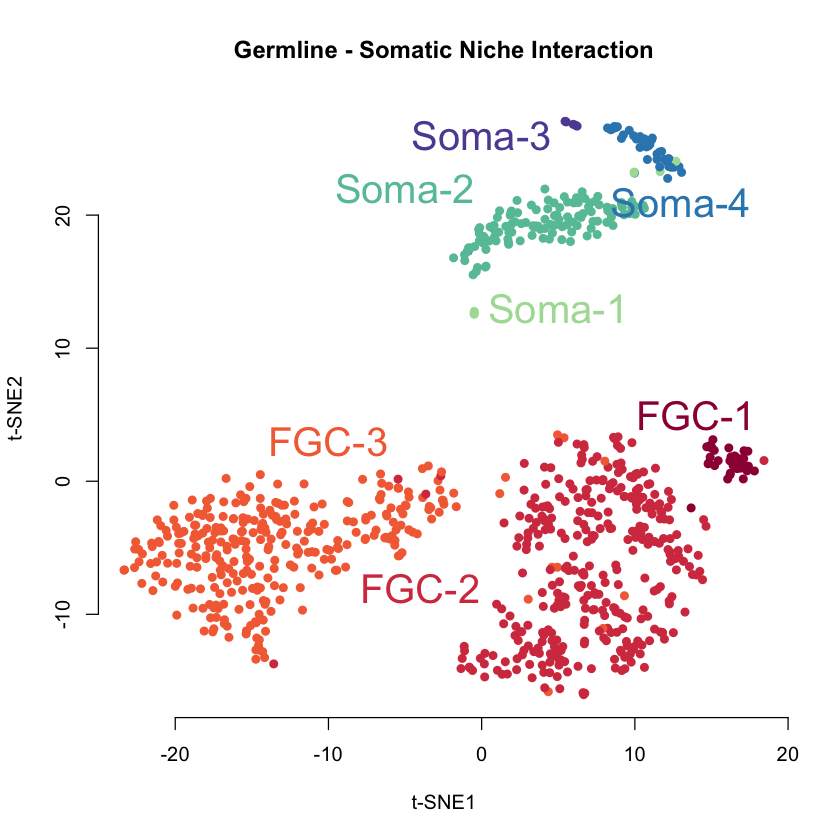

In [4]:
par(ask=FALSE)
plot(tsneGermMale$Y, col=labelGermMale,
	pch=16, main="Germline - Somatic Niche Interaction",
	xlab="t-SNE1", ylab="t-SNE2", bty="n")

text(14, 5, "FGC-1", col="#9E0142", cex=2)
text(-4, -8, "FGC-2", col="#D53E4F", cex=2)
text(-10, 3, "FGC-3", col="#F46D43", cex=2)
text(5, 13, "Soma-1", col="#ABDDA4", cex=2)
text(-5, 22, "Soma-2", col="#66C2A5", cex=2)
text(0, 26, "Soma-3", col="#5E4FA2", cex=2)
text(13, 21, "Soma-4", col="#3288BD", cex=2)

scTensorの入力は、[SingleCellExperiment](https://www.bioconductor.org/packages/release/bioc/html/SingleCellExperiment.html)パッケージで定義された、SingleCellExperimentオブジェクトである必要があります

SingleCellExperimentオブジェクトの作成は簡単で、SingleCellExperimentという名前の関数に、発現量行列を以下のように指定するだけです

In [5]:
sce <- SingleCellExperiment(assays=list(counts = GermMale))

また、必須ではありませんが、最後のレポートの見やすさも考えて、推奨しているタスクとして、以下のようにこのsceオブジェクトに二次元の次元圧縮の座標を登録します

In [6]:
reducedDims(sce) <- SimpleList(TSNE=tsneGermMale$Y)

これにより、tsneGermMale$Yは、sceのreducedDimsという項目（スロット）に登録されたことがわかります

In [7]:
head(reducedDims(sce)$TSNE)

[,1]     [,2]     
M_4W_embryo1_sc52 16.27250 1.8273633
M_4W_embryo1_sc53 17.41540 1.1278984
M_4W_embryo1_sc54 16.20873 0.4803177
M_4W_embryo1_sc55 14.91489 1.8113621
M_4W_embryo1_sc56 14.90168 2.6814108
M_4W_embryo1_sc57 16.41085 1.1939982

正規化を行った遺伝子発現量をscTensorに与えることもできます

例えば、細胞ごとの総発現量が、全細胞の総発現量の中央値になるように補正を行う、[Count per Median (CPMED)](https://www.biorxiv.org/content/10.1101/642595v2)正規化は以下のように実行することができます

In [8]:
CPMED <- function(input){
    libsize <- colSums(input)
    median(libsize) * t(t(input) / libsize)
}
normcounts(sce) <- log10(CPMED(counts(sce)) + 1)

ここで、normcountsというスロットに正規化済みの値を登録したのは、正規化をしていないカウント値はcountsというスロットに登録してあるので、上書きしないように別のスロットを使いました

In [9]:
head(normcounts(sce))

M_4W_embryo1_sc52 M_4W_embryo1_sc53 M_4W_embryo1_sc54 M_4W_embryo1_sc55
72    3.372542          3.180208          3.129106          2.443883         
9510  1.033941          0.000000          0.000000          0.000000         
11096 0.000000          0.000000          2.346654          0.000000         
133   0.000000          0.000000          0.000000          0.000000         
203   1.630864          0.000000          0.000000          0.000000         
205   1.605017          2.455575          0.000000          1.295497         
      M_4W_embryo1_sc56 M_4W_embryo1_sc57 M_4W_embryo1_sc58 M_4W_embryo1_sc59
72    3.1188225         3.542010          2.7537119         3.443081         
9510  0.0000000         0.000000          0.5103906         1.404802         
11096 0.0000000         0.000000          0.0000000         0.000000         
133   0.0000000         0.000000          0.0000000         0.000000         
203   0.0000000         0.000000          1.6829512         0.000000         
205   0.9817045         2.096723          2.2405461         2.008933         
      M_4W_embryo1_sc60 M_4W_embryo1_sc61 ⋯ M_25W_embryo1_107_sc37
72    1.948398          3.477690          ⋯ 0.000000              
9510  0.000000          0.000000          ⋯ 0.000000              
11096 1.948398          1.662157          ⋯ 0.000000              
133   0.000000          0.000000          ⋯ 0.000000              
203   0.000000          0.000000          ⋯ 2.341932              
205   2.430406          2.043583          ⋯ 1.336264              
      M_25W_embryo1_107_sc39 M_25W_embryo1_107_sc40 M_25W_embryo1_107_sc42
72    1.777100               1.668649               0.000000              
9510  0.000000               1.404941               1.709215              
11096 0.000000               0.000000               0.000000              
133   0.000000               0.000000               1.141891              
203   0.000000               0.000000               1.740779              
205   2.615877               2.881289               1.307666              
      M_25W_embryo1_107_sc44 M_25W_embryo1_107_sc47 M_25W_embryo1_107_sc49
72    1.397202               1.795183               1.843969              
9510  0.000000               0.000000               0.000000              
11096 0.000000               0.000000               0.000000              
133   0.000000               0.000000               0.000000              
203   0.000000               1.305041               0.000000              
205   1.580066               2.318540               2.080181              
      M_25W_embryo1_107_sc50 M_25W_embryo1_107_sc51 M_25W_embryo1_107_sc52
72    0.6408603              1.7689313              3.218885              
9510  0.0000000              0.6634365              0.000000              
11096 0.0000000              0.0000000              0.000000              
133   0.0000000              0.0000000              0.000000              
203   2.0746121              1.8192414              0.000000              
205   1.0453808              1.5006950              1.891234

In [10]:
head(counts(sce))

M_4W_embryo1_sc52 M_4W_embryo1_sc53 M_4W_embryo1_sc54 M_4W_embryo1_sc55
72    1078.47           683.13            685.63            198.07           
9510     4.49             0.00              0.00              0.00           
11096    0.00             0.00            112.72              0.00           
133      0.00             0.00              0.00              0.00           
203     19.10             0.00              0.00              0.00           
205     17.97           128.42              0.00             13.41           
      M_4W_embryo1_sc56 M_4W_embryo1_sc57 M_4W_embryo1_sc58 M_4W_embryo1_sc59
72    1067.78           1566.38           326.22            1559.27          
9510     0.00              0.00             1.29              13.72          
11096    0.00              0.00             0.00               0.00          
133      0.00              0.00             0.00               0.00          
203      0.00              0.00            27.19               0.00          
205      6.98             55.75            99.68              56.84          
      M_4W_embryo1_sc60 M_4W_embryo1_sc61 ⋯ M_25W_embryo1_107_sc37
72     43.77            1099.96           ⋯   0.00                
9510    0.00               0.00           ⋯   0.00                
11096  43.77              16.46           ⋯   0.00                
133     0.00               0.00           ⋯   0.00                
203     0.00               0.00           ⋯ 151.93                
205   133.81              40.13           ⋯  14.37                
      M_25W_embryo1_107_sc39 M_25W_embryo1_107_sc40 M_25W_embryo1_107_sc42
72     32.63                  49.58                  0.00                 
9510    0.00                  26.52                 42.53                 
11096   0.00                   0.00                  0.00                 
133     0.00                   0.00                 10.90                 
203     0.00                   0.00                 45.80                 
205   228.38                 825.64                 16.36                 
      M_25W_embryo1_107_sc44 M_25W_embryo1_107_sc47 M_25W_embryo1_107_sc49
72    39.29                   40.42                 33.36                 
9510   0.00                    0.00                  0.00                 
11096  0.00                    0.00                  0.00                 
133    0.00                    0.00                  0.00                 
203    0.00                   12.63                  0.00                 
205   60.72                  136.42                 57.82                 
      M_25W_embryo1_107_sc50 M_25W_embryo1_107_sc51 M_25W_embryo1_107_sc52
72     1.69                  47.06                  1286.08               
9510   0.00                   2.94                     0.00               
11096  0.00                   0.00                     0.00               
133    0.00                   0.00                     0.00               
203   58.98                  52.94                     0.00               
205    5.06                  25.00                    59.74

次に、cellCellSettingという関数を使って、scTensorに必要なセッティング（リガンド・受容体ペアの検索、ラベル情報の登録など）を行います

In [11]:
cellCellSetting(sce, LRBase.Hsa.eg.db, labelGermMale, names(labelGermMale))

cellCellRanks関数は、このすぐ後のcellCellDecomp関数で実行するテンソル分解のランク（圧縮次元数）のパラメーターを簡易的に設定します

例えば、このデータでは、リガンドパターンと受容体パターン（後述）は各々4,3と見積もりました

In [12]:
rks <- cellCellRanks(sce, assayNames="normcounts")
rks$selected

[1] 4 3

最後に、cellCellDecomp関数で、非負値テンソル分解を行います

ランクはc(4,3)とし、正規化済みの値（normcounts）をここでは使うことにします

In [13]:
set.seed(1234)
cellCellDecomp(sce, ranks=rks$selected, assayNames="normcounts")

Input data matrix may contains 7 gene symbols because the name contains some alphabets.
scTensor uses only NCBI Gene IDs for now.
Here, the gene symbols are removed and remaining 235 NCBI Gene IDs are used for scTensor next step.
7 * 7 * 84 Tensor is created


これにより、

7×7×84の三階テンソル（$χ$）は、

$\chi = G A B$

$A$（4×7, 因子行列）: 7細胞型におけるリガンドの発現の仕方4パターン

$B$（3×7, 因子行列）: 7細胞型における受容体の発現の仕方3パターン

$G$（4×3×84, コアテンソル）: 各リガンド・受容体ペアごとに、$A$の4パターンと$B$の3パターンの全組み合わせのうち、どの組み合わせと関連度が高いか


と分解されます。




最後に、cellCellReport関数で、HTMLレポートを出力します

ここでは、Rのセッションを閉じると自動的に削除される一時ディレクトリ（**tempdir**）以下に、レポートファイルを保存しますが、自分のデータでscTensorを実行する際には、適宜自分の好きなところに設定したください

**title**にこのレポートのタイトルを、**author**にこの解析の担当者名を書きます

ここでは、**display_html**関数を使って、このノートブックにHTMLの出力を埋め込むので、あえて**html.open=FALSE**としていますが、ここをTRUEにするとレポートがWebブラウザで確認することもできます

**upper**はどの細胞型と、どの細胞型とが、何のリガンド・受容体ペアで相互作用しているのか、という三項関係をレポートする際に、コアテンソルの大きい上位2つのみに注目するというオプションです（ここでは最大4*3=12まで見ることができます）

**〜enrich**のところは、遺伝子の機能を調べる際に、エンリッチメント解析を行うのですが、その時にGene Ontology（GO）のみを使うとしています


snapshotDate(): 2019-05-02
downloading 0 resources
loading from cache 
    'AH70572 : 77318'
Loading required package: AnnotationDbi
Related gene names are retrieved from AnnotationHub...
'select()' returned 1:1 mapping between keys and columns
Related gene descriptions are retrieved from AnnotationHub...
'select()' returned 1:1 mapping between keys and columns
Related GO IDs are retrieved from AnnotationHub...
'select()' returned 1:many mapping between keys and columns
Related Ensembl Gene IDs are retrieved from AnnotationHub...
'select()' returned 1:many mapping between keys and columns
Related Ensembl Protein IDs are retrieved from AnnotationHub...
'select()' returned 1:many mapping between keys and columns
Related UniProtKB IDs are retrieved from AnnotationHub...
'select()' returned 1:many mapping between keys and columns
Related MeSH IDs are retrieved from MeSH.XXX.eg.db-type package...
Related Reactome IDs are retrieved from reactome.db package...
2 LR vectors will be calculated 

GO-Enrichment Analysis is running...(1/3)


Loading required package: org.Hs.eg.db


GO-Enrichment Analysis is running...(2/3)
GO-Enrichment Analysis is running...(3/3)
Hyper-links are embedded...
GO-Enrichment Analysis is running...(1/3)
GO-Enrichment Analysis is running...(2/3)
GO-Enrichment Analysis is running...(3/3)
Hyper-links are embedded...


ligand.Rmd is created...
receptor.Rmd is created...
ligand_all.Rmd is created...
receptor_all.Rmd is created...
ligand.Rmd is compiled to ligand.html...
ligand_all.Rmd is compiled to ligand_all.html...
receptor.Rmd is compiled to receptor.html...
receptor_all.Rmd is compiled to receptor_all.html...
2 pattern_X_Y.Rmd files are compiled to pattern_X_Y.html :



pattern_2_2.Rmd is created...


pattern_2_2.Rmd is compiled to pattern_2_2.html



pattern_2_1.Rmd is created...


pattern_2_1.Rmd is compiled to pattern_2_1.html
index.Rmd is created...
index.Rmd is compiled to index.html...
################################################
Data files are saved in
/var/folders/k0/tk8gl4bj2_v2mbjx80ydsznw0000gn/T//RtmplBZnv3
################################################



<!DOCTYPE html>

 

 

 
 
 
 


 


 Cell-cell interaction within Germline_Male, GSE86146
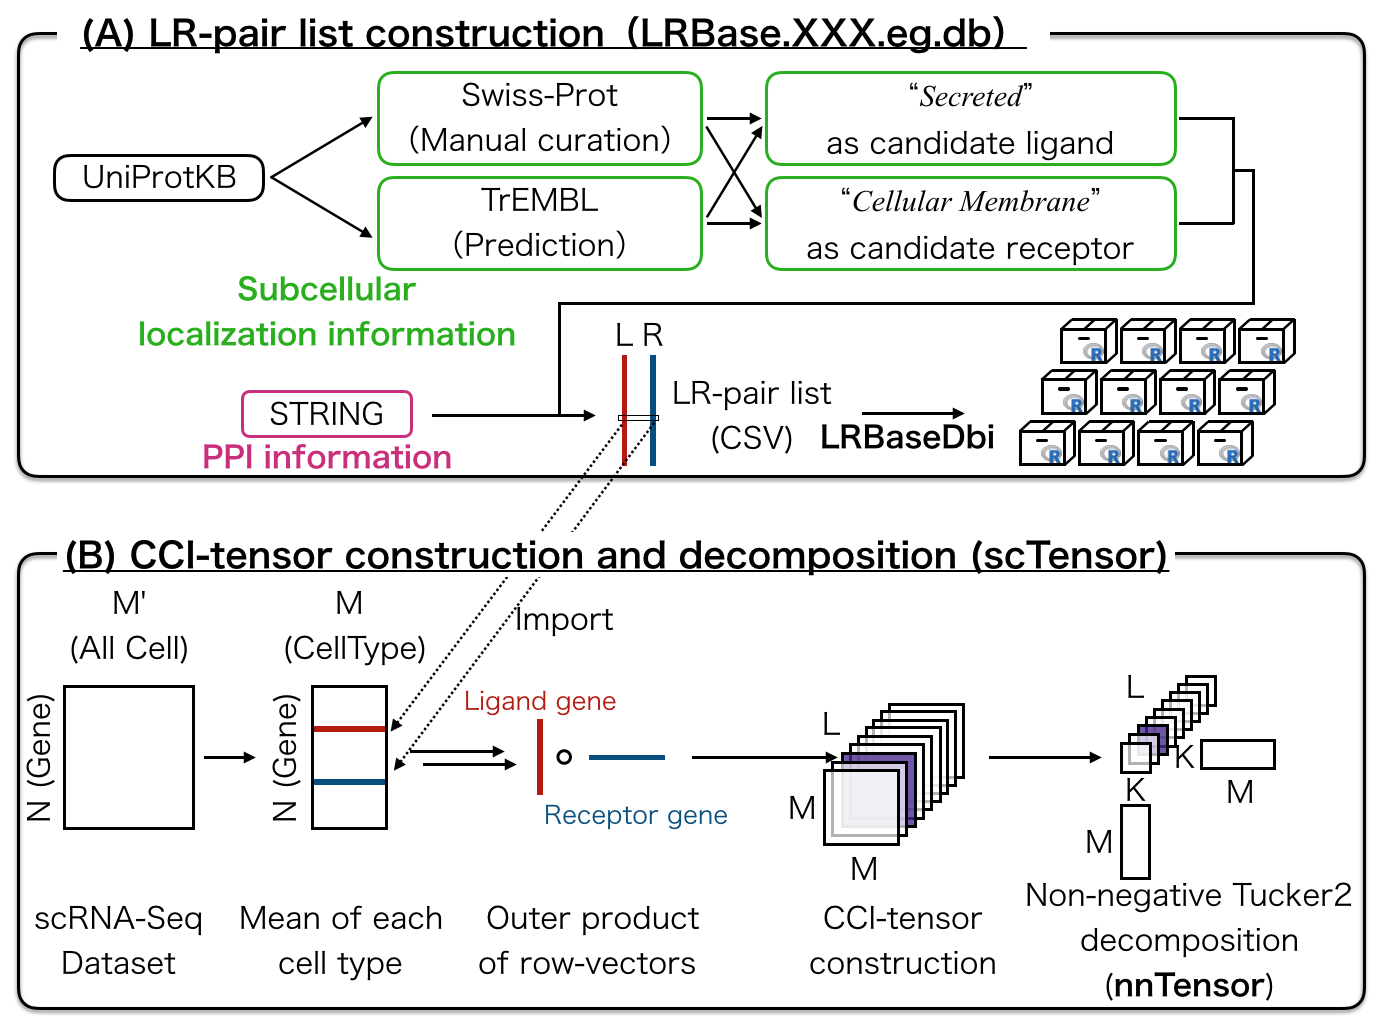
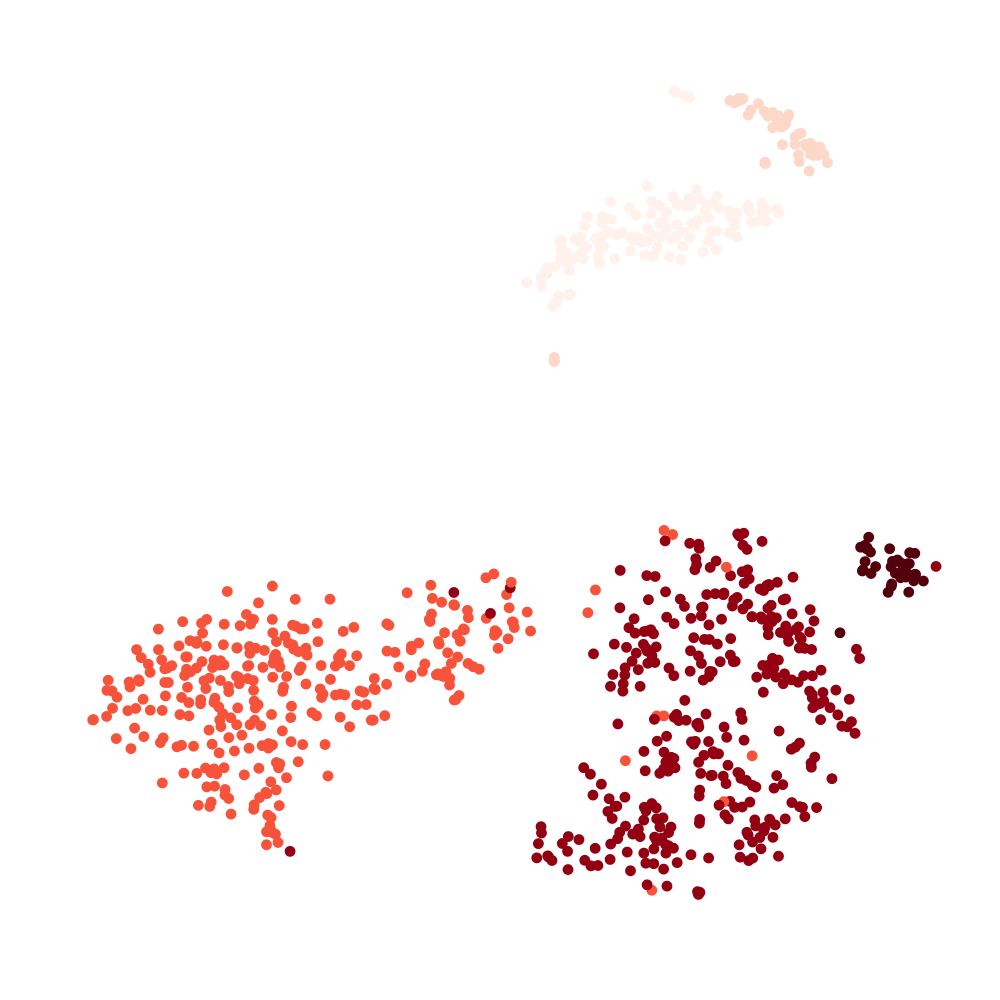
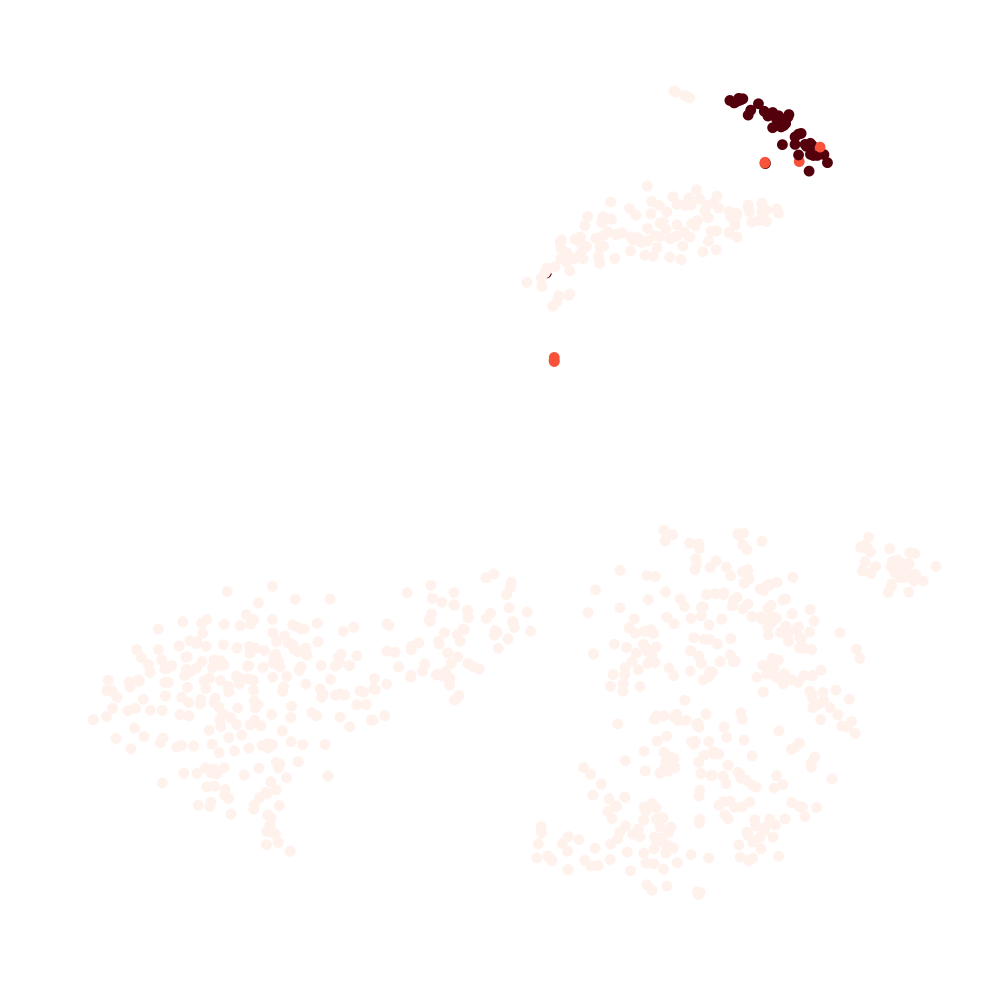
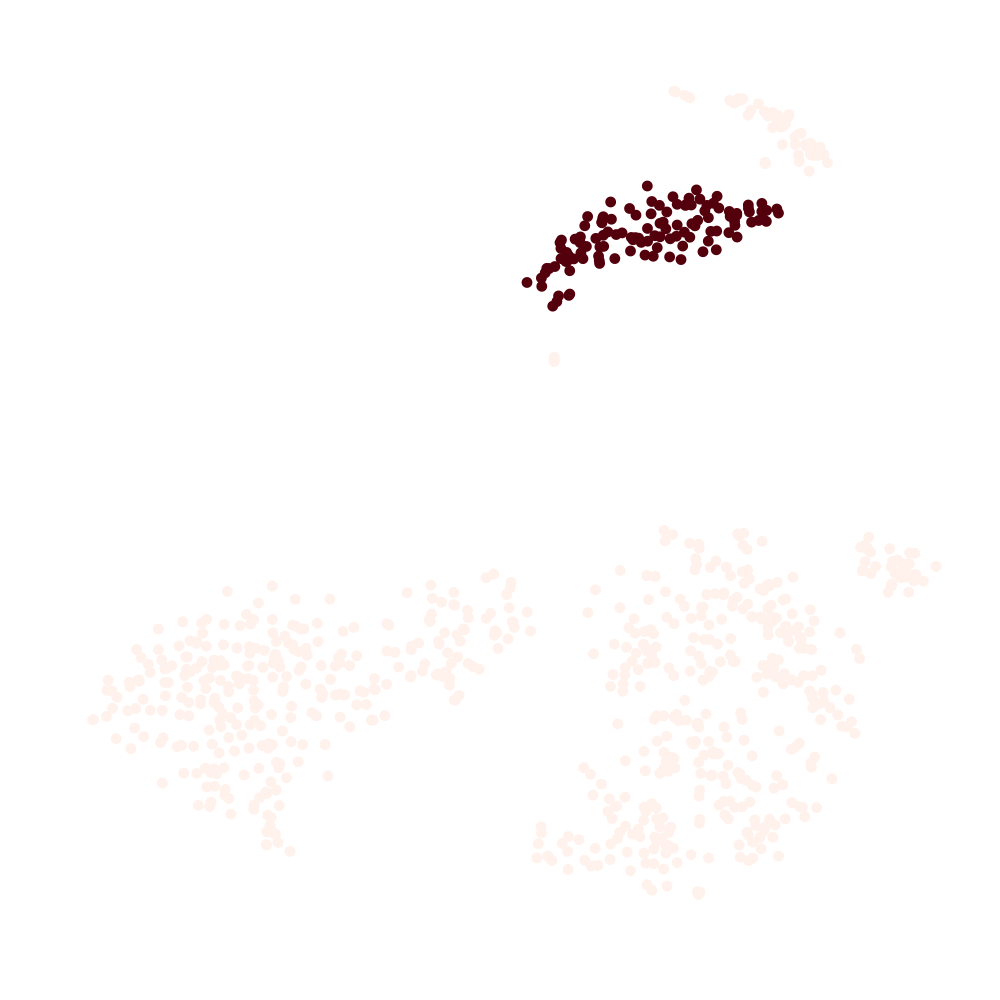
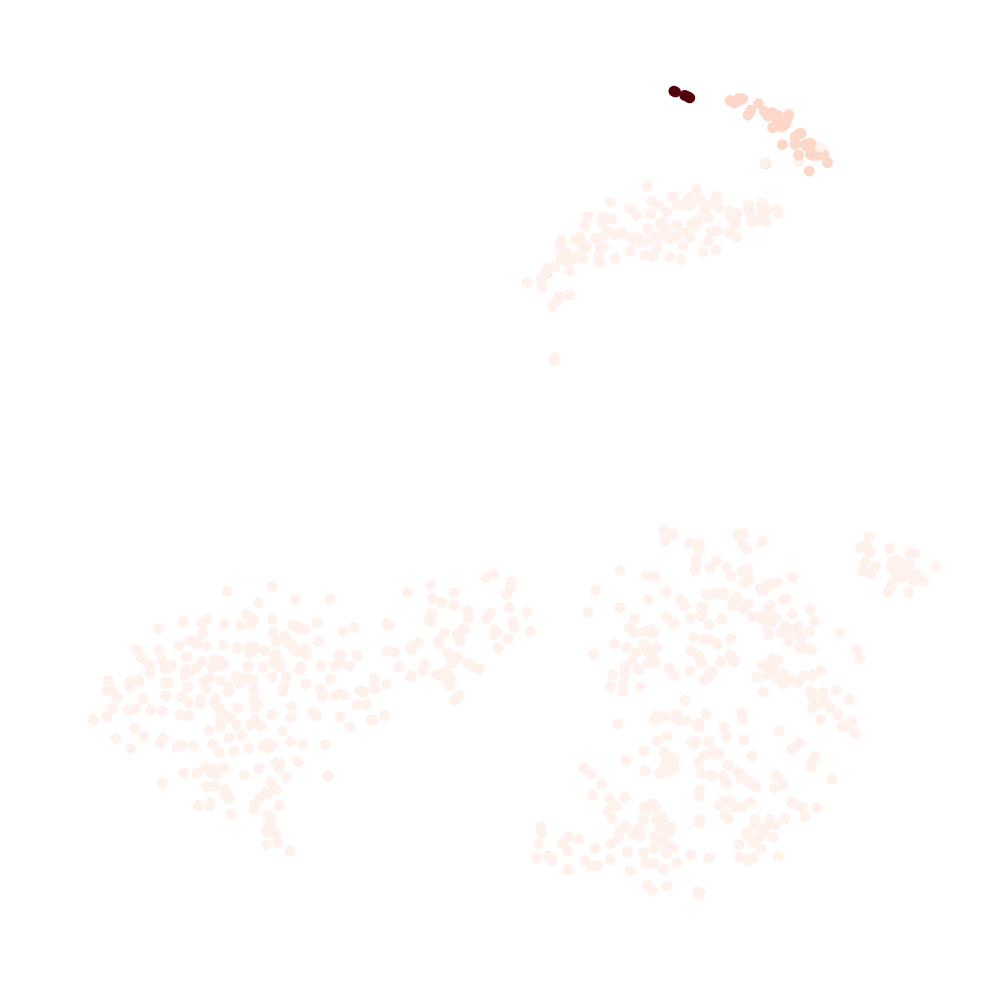
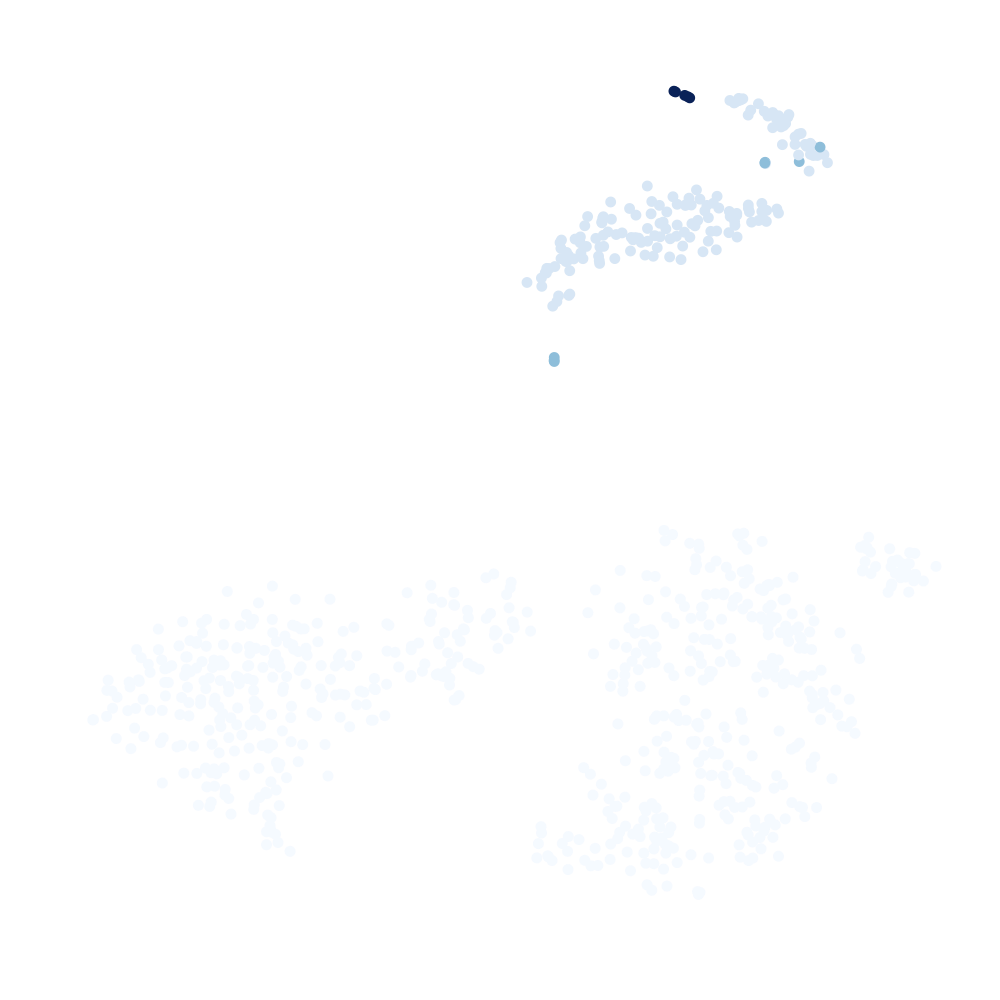
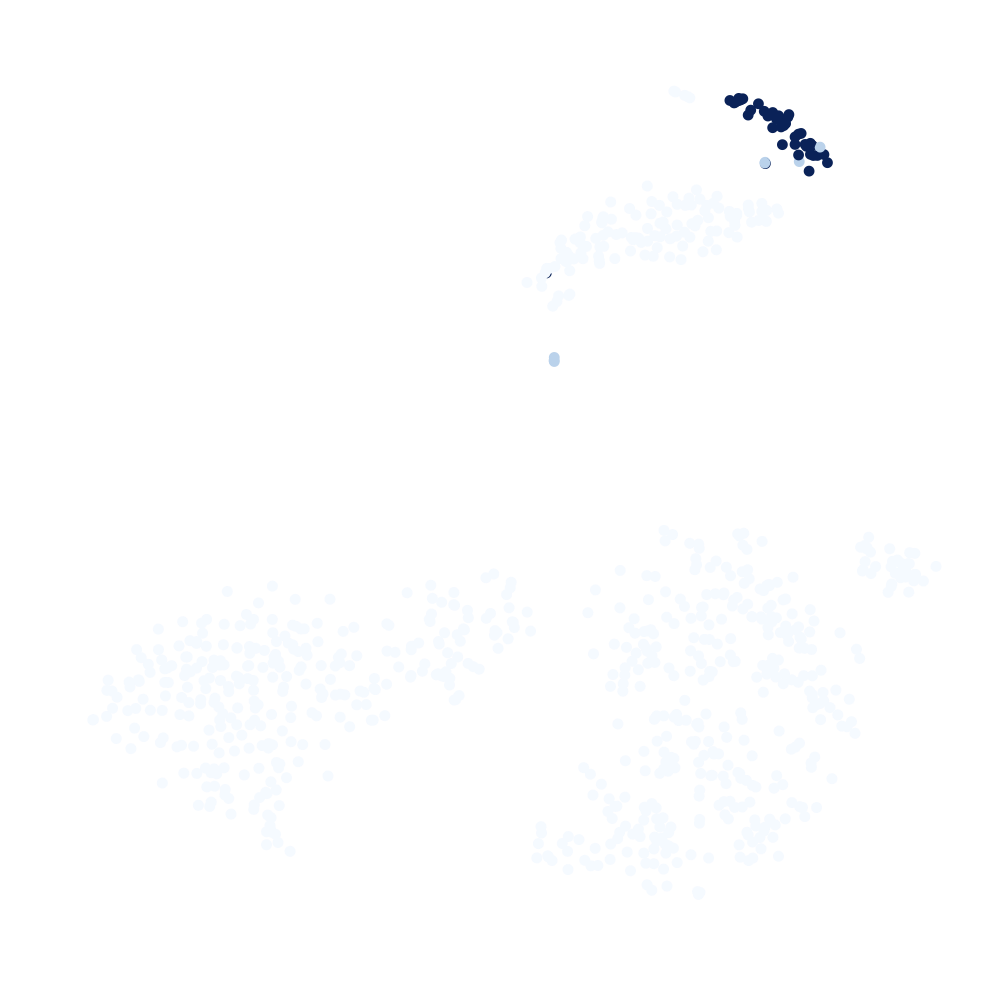
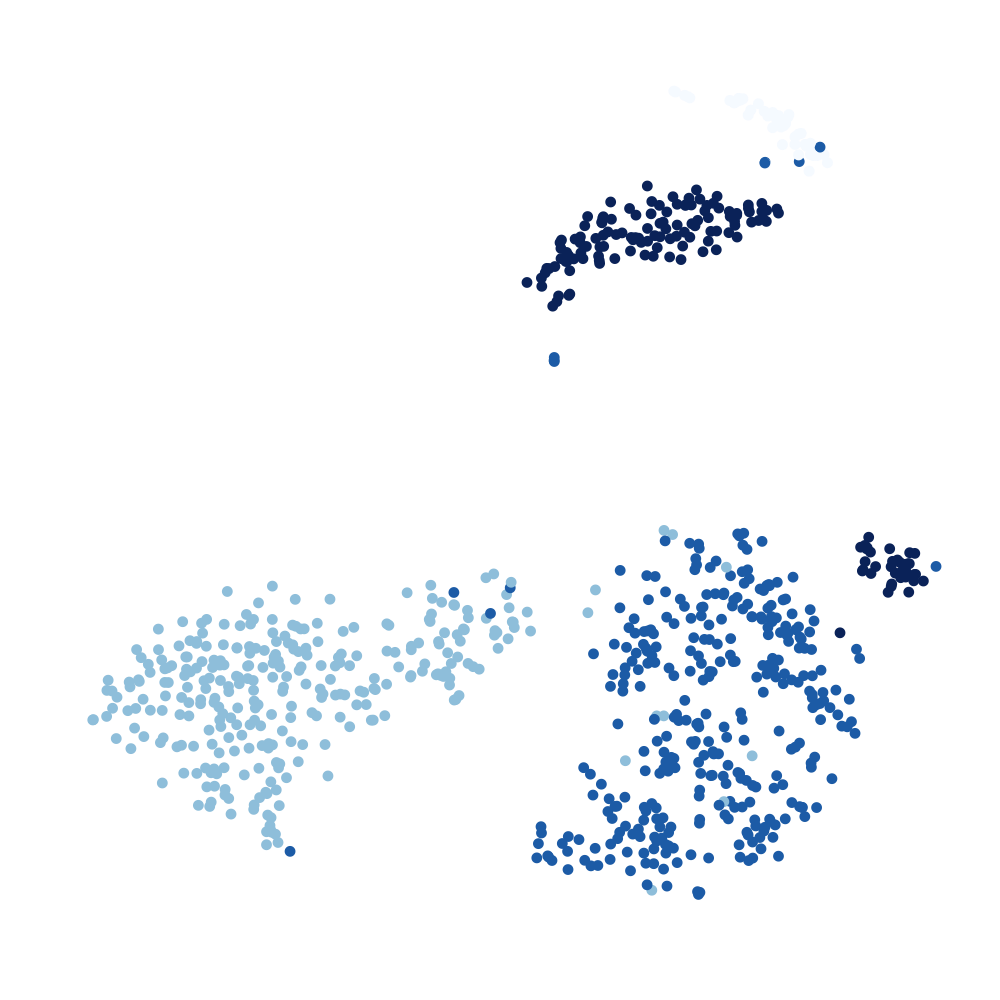
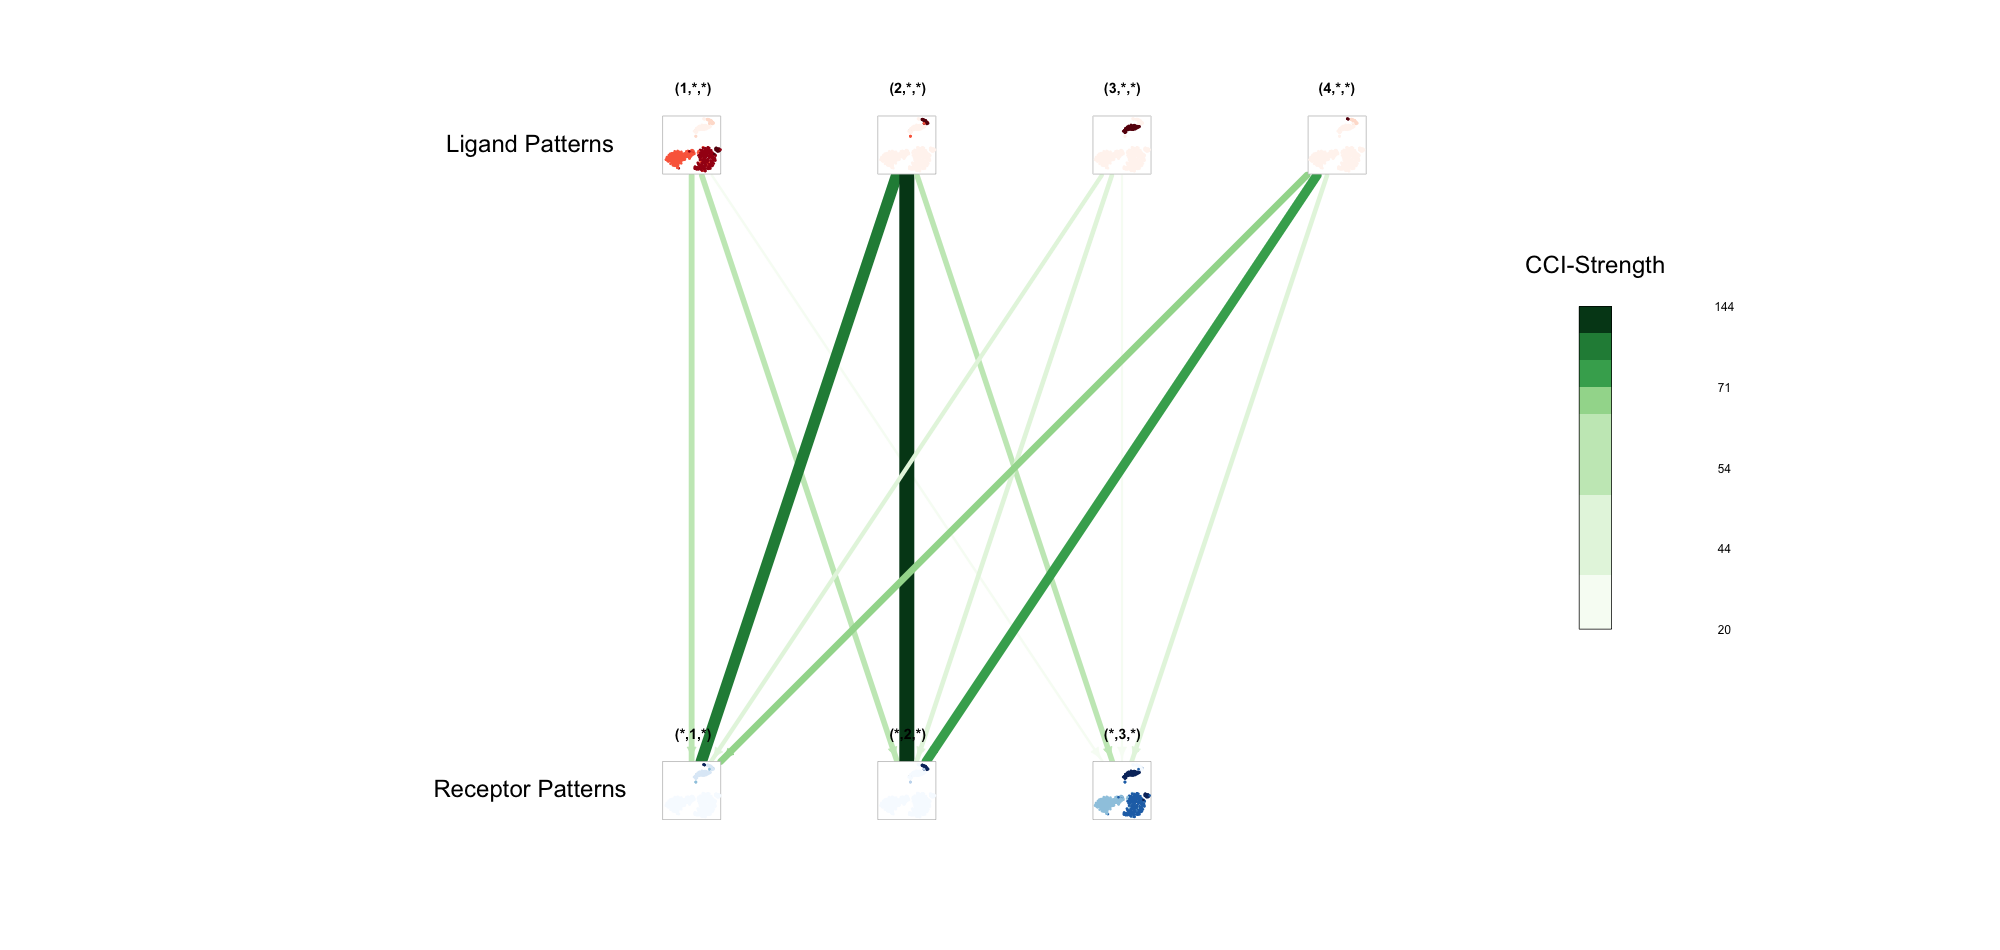

In [14]:
d <- tempdir()
cellCellReport(sce, reducedDimNames="TSNE", assayNames="normcounts",
    title="Cell-cell interaction within Germline_Male, GSE86146",
    author="Koki Tsuyuzaki", html.open=FALSE, upper=2, out.dir=d,
    goenrich=TRUE, meshenrich=FALSE, reactomeenrich=FALSE,
    doenrich=FALSE, ncgenrich=FALSE, dgnenrich=FALSE)
display_html(file=paste0(d, "/index.html"))

出力されたHTMLレポート（index.html）をダブルクリックすると、Webブラウザで以下のようなレポートを見ることができます


このHTMLレポートは、この画面上で何でも調べ物ができるように作ってありますが、そのためかなり情報が多いので、ここでは開発者おすすめの読み進み方を紹介します

まずは、**5. CCI-wise Hypergraph**を見てください

<p><img alt="cciwise" width="1000" src="https://dl.dropboxusercontent.com/s/xbc6bmlx46nekhg/cciwise.png" /></p>


この図は今回のCCIテンソルの分解（$\chi = G A B$）を可視化しています

**Ligand Patterns**と書かれている上の段は、因子行列Aであり、色が赤くなるほど、リガンドがそこで発現する傾向があり、分解時に指定したパラメーターにより、このようなリガンドの発現の仕方が4パターンあるとしています

同様に、**Receptor Patterns**と書かれている下の段は、因子行列Bであり、色が青くなるほど、受容体がそこで発現する傾向があり、分解時に指定したパラメーターにより、このような受容体の発現の仕方が3パターンあるとしています

また**CCI-Strength**は、コアテンソル$G$（4×3×84）を、奥行き方向で和をとることで4×3の行列にして、その値を緑の線の太さに反映させて見せています

つまり、この図で言えることは、**Ligand Patternsの2番目のパターンのようなリガンドの発現の仕方と、Receptor Patternsの2番目のパターンのような受容体の発現の仕方の組み合わせによるCCIが、データ全体で見ると多い**ことがわかります

なお、このLigand/Receptor Patternsの何番目のパターンは、どの細胞型と対応しているのかというのは、**3. Ligand-Cell Patterns**や**4. Receptor-Cell Patterns**のところを見ることでわかります

例えば、Ligand Patternsの2番目は、Male_Soma1やMale_Soma3といった細胞型名であることがわかります

<p><img alt="ligand" width="1000" src="https://dl.dropboxusercontent.com/s/llq53fkjncx76i8/LigandPatterns.png" /></p>
<p><img alt="ligand2" width="1000" src="https://dl.dropboxusercontent.com/s/02yhnj45apd7b68/LigandPatterns_2.png" /></p>

また、例えば、Receptor Patternsの2番目は、Male_Soma3といった細胞型名であることがわかります

<p><img alt="receptor" width="1000" src="https://dl.dropboxusercontent.com/s/1tsg6x3h8hik1fi/ReceptorPatterns.png" /></p>

<p><img alt="receptor2" width="1000" src="https://dl.dropboxusercontent.com/s/fsd65x5ds3ysm9r/ReceptorPatterns_2.png" /></p>

このような同じ細胞型同士でのCCIは、あまり論文では注目されない傾向がありますが（異種細胞型間が多い）、実データでは良く目にします

では、どの細胞型同士がCCIしているのかというのはここでわかりましたが、これらが具体的にどのリガンド・受容体同士でCCIしているのか、**三項関係**を調べたいと思います

これは**7. (Ligand-Cell, Receptor-Cell,)-related L-R Pairs**という項目で調べることができます

ここでは、**CCI-Strength**の時と同様に、コアテンソルの値の大きさでソートして三項関係をリスト化しています

<p><img alt="triplet" width="1000" src="https://dl.dropboxusercontent.com/s/zirjql3z1ua4eyr/Triplet.png" /></p>

例えば、ここでは、7.1のところに、2番目のリガンドパターン、2番目の受容体パターンと関係したリガンド・受容体ペアの情報が書かれているので、クリックしてみます

(2,2,)パターンがまず赤線で確認することができます
<p><img alt="triplet2" width="1000" src="https://dl.dropboxusercontent.com/s/lprhs8e4zmzqpyb/Triplet2.png" /></p>


このパターンと関係度が高いリガンド・受容体ペアは12あるということがわかります

これらペア同士をエッジで繋いで、赤いノードはリガンド、青いノードは受容体として、ネットワーク図も描いています

この図はインタラクティブに配置を移動することができるので、論文の図で利用する時などは、色々調整するのに便利です
<p><img alt="triplet3" width="1000" src="https://dl.dropboxusercontent.com/s/izvib230b8gz4pe/Triplet3.png" /></p>

この12のリガンド・受容体ペアに関するあらゆる情報をリストにしているので、調べ物をする時は、ここのリンクを辿ると良いでしょう
<p><img alt="triplet4" width="1000" src="https://dl.dropboxusercontent.com/s/63y089z59wkiyda/Triplet4.png" /></p>

また、この12のリガンド・受容体ペアが発現するというのは生物学的にどういう意味があるのかを調べるために、エンリッチメント解析を行い、あらゆる機能タームとの関連性を調べています
<p><img alt="triplet5" width="1000" src="https://dl.dropboxusercontent.com/s/a9x403s2idwt5m4/Triplet5.png" /></p>

最後に、検出された三項関係が、自分の知識と一致するのかを調べるために、**6. Gene-wise Hypergraph**のところを見ます


<p><img alt="genewise" width="1000" src="https://dl.dropboxusercontent.com/s/vl3cc1nbp7ohwvn/genewise.png" /></p>


例えば、自分がDCN（[Decorin](https://en.wikipedia.org/wiki/Decorin)、プロテオグリカンの一つで細胞外マトリックスの構成要素の一つ）に興味がある研究者である場合、DCNがリガンドとして働くのがわかっているのであれば、

**Details of Ligand Gene-centric Overview (selected)**

のところで調べることができます

これらは先ほどの三項関係のリストで、一度でも関連性が見られたリガンド・受容体（selected）だけを厳選して、リガンドごとに集約したリストにしています


例えば、ここではDCNはPDGFRAやPDGFRBと共発現していること、またそれらの共発は、(4,1,)パターンや、(4,3,)パターンといったCCIの仕方と関係しているということがわかります
<p><img alt="dcn" width="1000" src="https://dl.dropboxusercontent.com/s/i2carph2go7o6ze/DCN.png" /></p>


逆に、注目している受容体がある場合は、

**Details of Receptor Gene-centric Overview (selected)**

のところを調べると、受容体ごとに集約されたリストを見ることができます


また、全リガンド受容体ペア（LRBase.XXX.eg.db内の全リスト）のうち、そもそもCCIテンソルの中に含まれているのかは、


**Details of Ligand Gene-centric Overview (all)**

や

**Details of Receptor Gene-centric Overview (all)**

をクリックすることで調べることができます

In [15]:
sessionInfo()

R version 3.6.1 (2019-07-05)
Platform: x86_64-apple-darwin15.6.0 (64-bit)
Running under: macOS Catalina 10.15.1

Matrix products: default
BLAS:   /Library/Frameworks/R.framework/Versions/3.6/Resources/lib/libRblas.0.dylib
LAPACK: /Library/Frameworks/R.framework/Versions/3.6/Resources/lib/libRlapack.dylib

locale:
[1] C/UTF-8/C/C/C/C

attached base packages:
[1] parallel  stats4    stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] heatmaply_0.16.0            viridis_0.5.1              
 [3] viridisLite_0.3.0           BiocStyle_2.12.0           
 [5] plotly_4.9.1                ggplot2_3.2.1              
 [7] GO.db_3.8.2                 org.Hs.eg.db_3.8.2         
 [9] AnnotationDbi_1.46.1        IRdisplay_0.7.0            
[11] MeSH.Hsa.eg.db_1.12.0       MeSHDbi_1.20.0             
[13] LRBase.Hsa.eg.db_1.1.0      LRBaseDbi_1.2.0            
[15] SingleCellExperiment_1.6.0  SummarizedExperiment_1.14.1
[17] DelayedArray_0.10.0    

Colaboratory ノートブックの操作について詳しくは、<a href="/notebooks/basic_features_overview.ipynb">Colaboratory の概要</a>をご覧ください。